# Control of a "spacecraft" platform with a reaction wheel

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

# This is my own script (it is an interface to the pybullet simulator)
import ae353_platform

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_platform)

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create an instance of the robot simulator. This will open a window in which you should see the reaction wheel.

There are four optional parameters:

* `damping` is the coefficient of viscous friction at each joint (the default value is `0.`)
* `pitch` is the angle of the ground in radians (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.001`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
robot = ae353_platform.RobotSimulator(damping=0., pitch=0., dt=0.01, display=True)

Get linearized model of platform (ignoring wheel):

In [3]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# Convert floats to rationals
l_sym = sym.nsimplify(l)
mw_sym = sym.nsimplify(mw)
Jp_sym = sym.nsimplify(Jp)

# Create symbolic variables
q, v, tau = sym.symbols('q, v, tau', real=True)

# Define equations of motion
f = sym.Matrix([[v], [(1 / (Jp_sym + mw_sym * l_sym**2)) * tau]])

# Equilibrium point
qe = 0.
ve = 0.
taue = 0.

# Linearized state space model
A_num = sym.lambdify((q, v, tau), f.jacobian([q, v]))
B_num = sym.lambdify((q, v, tau), f.jacobian([tau]))
A = A_num(qe, ve, taue).astype(float)
B = B_num(qe, ve, taue).astype(float)

Do optimal control design:

In [4]:
# Choose gains
Q = np.diag([1., 1.])
R = np.diag([1.])

# Find optimal cost matrix
P = linalg.solve_continuous_are(A, B, Q, R)

# Find optimal gain matrix
K = linalg.inv(R) @  B.T @ P
print(f'K = {K.tolist()}')

# Find the closed-loop eigenvalues
print(f's = {linalg.eigvals(A - B @ K)}')

K = [[0.9999999999999998, 1.7320508075688774]]
s = [-0.8660254+0.5j -0.8660254-0.5j]


## Full state feedback

In [ ]:
class RobotController:
    def __init__(self, dt=0.01, K=None, q_des=0.):
        self.dt = dt
        
        # Choose equilibrium point
        self.q_e = q_des
        self.v_e = 0.
        self.v_wheel_e = 0.
        self.tau_e = 0.
        
        # Choose state feedback gains
        self.K = K
    
    def run(self, q, v, q_wheel, v_wheel):
        """
        INPUTS
         q = angle of platform (rad)
         v = angular velocity of platform (rad/s)
         q_wheel = angle of wheel with respect to platform (rad)
         v_wheel = angular velocity of wheel with respect to platform (rad/s)
        
        OUTPUTS
         tau = torque applied to wheel by motor on platform (N m)
        """
        
        # find x
        x = np.array([[q - self.q_e], [v - self.v_e]])
        
        # find u
        u = - self.K @ x
        
        # find the torque that we want applied to the platform
        tau_on_platform = u[0, 0] + self.tau_e
        
        
        # find the torque that would have to be applied to the wheel
        tau = - tau_on_platform
        
        return tau

controller = RobotController(dt=robot.dt, K=K)

In [ ]:
##############################################
# Restore the simulation to its initial state
#

# Choose initial conditions
q_platform = controller.q_e + 1.
q_wheel = 0.
v_platform = 0.
v_wheel = 0.

# Apply initial conditions
robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

# - could also use:
#
#       robot.reset()
#
##############################################


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q, v, q_wheel, v_wheel = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q, v, q_wheel, v_wheel)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q
    data['v'][step] = v
    data['q_wheel'][step] = q_wheel
    data['v_wheel'][step] = v_wheel
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

In [ ]:
del q
del v
del q_wheel
del v_wheel

## Partial state feedback

### Change nothing

In [ ]:
class RobotController:
    def __init__(self, dt=0.01, K=None, q_des=0.):
        self.dt = dt
        
        # Choose equilibrium point
        self.q_e = q_des
        self.v_e = 0.
        self.v_wheel_e = 0.
        self.tau_e = 0.
        
        # Choose state feedback gains
        self.K = K
        
        # Initialize state estimate
        self.xhat = np.zeros((2, 1))
        
        self.C = np.array([[1., 0.]])
    
    def run(self, q):
        """
        INPUTS
         q = angle of platform (rad)
        
        OUTPUTS
         tau = torque applied to wheel by motor on platform (N m)
        """
        
        # find x
        x = np.array([[q - self.q_e], [v - self.v_e]])
        
        # find u
        u = - self.K @ x
        
        # find the torque that we want applied to the platform
        tau_on_platform = u[0, 0] + self.tau_e
        
        # find the torque that would have to be applied to the wheel
        tau = - tau_on_platform
        
        # find xhat
        self.xhat = x.copy()
        
        return tau

controller = RobotController(dt=robot.dt, K=K)

In [ ]:
##############################################
# Restore the simulation to its initial state
#

# Choose initial conditions
q_platform = controller.q_e + 1.
q_wheel = 0.
v_platform = 0.
v_wheel = 0.

# Apply initial conditions
robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

# - could also use:
#
#       robot.reset()
#
##############################################


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'xhat': np.empty((2, num_steps), dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_true, v_true, q_wheel_true, v_wheel_true = robot.get_sensor_measurements()
    
    # Add noise to sensor measurements
    q_meas = q_true
    
    # Log the state estimate
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q_meas)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q_true
    data['v'][step] = v_true
    data['q_wheel'][step] = q_wheel_true
    data['v_wheel'][step] = v_wheel_true
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

### Try solving for x

In [ ]:
class RobotController:
    def __init__(self, dt=0.01, K=None, q_des=0.):
        self.dt = dt
        
        # Choose equilibrium point
        self.q_e = q_des
        self.v_e = 0.
        self.v_wheel_e = 0.
        self.tau_e = 0.
        
        # Define sensor model
        self.C = np.array([[1., 0.]])
        
        # Choose state feedback gains
        self.K = K
        
        # Initialize state estimate
        self.xhat = np.zeros((2, 1))
    
    def run(self, q):
        """
        INPUTS
         q = angle of platform (rad)
        
        OUTPUTS
         tau = torque applied to wheel by motor on platform (N m)
        """
        
        # find u
        u = - self.K @ self.xhat
        
        # find y
        y = np.array([[q - self.q_e]])
        
        # find xhat
        self.xhat = linalg.inv(self.C) @ y
        
        # find the torque that we want applied to the platform
        tau_on_platform = u[0, 0] + self.tau_e
        
        # find the torque that would have to be applied to the wheel
        tau = - tau_on_platform
        
        return tau

controller = RobotController(dt=robot.dt, K=K)

In [ ]:
##############################################
# Restore the simulation to its initial state
#

# Choose initial conditions
q_platform = controller.q_e + 1.
q_wheel = 0.
v_platform = 0.
v_wheel = 0.

# Apply initial conditions
robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

# - could also use:
#
#       robot.reset()
#
##############################################


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'xhat': np.empty((2, num_steps), dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_true, v_true, q_wheel_true, v_wheel_true = robot.get_sensor_measurements()
    
    # Add noise to sensor measurements
    q_meas = q_true
    
    # Log the state estimate
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q_meas)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q_true
    data['v'][step] = v_true
    data['q_wheel'][step] = q_wheel_true
    data['v_wheel'][step] = v_wheel_true
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

# Extract estimates of q and v
q_est = data['xhat'][0, :] + controller.q_e
v_est = data['xhat'][1, :] + controller.v_e

# Compare estimates to real values
fig, (ax_q, ax_v, ax_tau) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

ax_q.plot(data['t'], data['q'], label='q', linewidth=4)
ax_q.plot(data['t'], q_est, '--', label='q (estimate)', linewidth=3)
ax_q.grid()
ax_q.legend(fontsize=16)
ax_q.tick_params(labelsize=14)

ax_v.plot(data['t'], data['v'], label='v', linewidth=4)
ax_v.plot(data['t'], v_est, '--', label='v (estimate)', linewidth=3)
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)

ax_tau.plot(data['t'], data['tau'], label='joint torque command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C1')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

### Try finite difference

In [6]:
class RobotController:
    def __init__(self, dt=0.01, K=None, q_des=0.):
        self.dt = dt
        
        # Choose equilibrium point
        self.q_e = q_des
        self.v_e = 0.
        self.v_wheel_e = 0.
        self.tau_e = 0.
        
        # Choose state feedback gains
        self.K = K
        
        # Initialize state estimate
        self.xhat = np.zeros((2, 1))
        
        # Initialize old output
        self.q_old = 0.
    
    def run(self, q):
        """
        INPUTS
         q = angle of platform (rad)
        
        OUTPUTS
         tau = torque applied to wheel by motor on platform (N m)
        """
        
        # find u
        u = - self.K @ self.xhat
        
        # estimate v by finite difference
        v = (q - self.q_old) / self.dt
        
        # find xhat
        self.xhat = np.array([[q - self.q_e], [v - self.v_e]])
        self.q_old = q
        
        # find the torque that we want applied to the platform
        tau_on_platform = u[0, 0] + self.tau_e
        
        # find the torque that would have to be applied to the wheel
        tau = - tau_on_platform
        
        return tau

controller = RobotController(dt=robot.dt, K=K)

(0.0, 9.99)

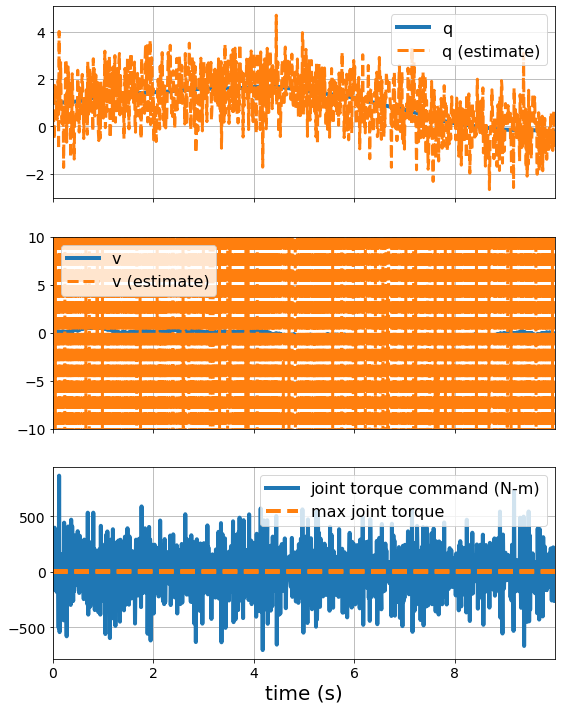

In [9]:
##############################################
# Restore the simulation to its initial state
#

# Choose initial conditions
q_platform = controller.q_e + 1.
q_wheel = 0.
v_platform = 0.
v_wheel = 0.

# Apply initial conditions
robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

# - could also use:
#
#       robot.reset()
#
##############################################


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'xhat': np.empty((2, num_steps), dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_true, v_true, q_wheel_true, v_wheel_true = robot.get_sensor_measurements()
    
    # Add noise to sensor measurements
    q_meas = q_true + np.random.randn()
    
    # Log the state estimate
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q_meas)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q_true
    data['v'][step] = v_true
    data['q_wheel'][step] = q_wheel_true
    data['v_wheel'][step] = v_wheel_true
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

# Extract estimates of q and v
q_est = data['xhat'][0, :] + controller.q_e
v_est = data['xhat'][1, :] + controller.v_e

# Compare estimates to real values
fig, (ax_q, ax_v, ax_tau) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

ax_q.plot(data['t'], data['q'], label='q', linewidth=4)
ax_q.plot(data['t'], q_est, '--', label='q (estimate)', linewidth=3)
ax_q.grid()
ax_q.legend(fontsize=16)
ax_q.tick_params(labelsize=14)

ax_v.plot(data['t'], data['v'], label='v', linewidth=4)
ax_v.plot(data['t'], v_est, '--', label='v (estimate)', linewidth=3)
ax_v.set_ylim([-10., 10.])
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)

ax_tau.plot(data['t'], data['tau'], label='joint torque command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C1')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

In [17]:
np.random.randn()

0.09358488294332896

### Try observer

In [13]:
class RobotController:
    """
    A 'class' allows functions to share a set of variables without
    having to make those variables 'global'.
    
    Our control design has a bunch of variables (the time step, the
    equilibrium point, the state-space model, the controller and observer
    gains, and the state estimate) that need to be shared among several
    different functions (to initialize everything, to reset the state
    estimate, and to run the controller and observer), so the use of a
    class is helpful.
        
    You can read more about classes here:
    
        https://docs.python.org/3/tutorial/classes.html
    
    We name this particular class 'RobotController'. Everything inside
    it must be indented.
    """
    
    def __init__(self):
        """
        This function is called once each time we create an instance of
        the class as:
        
            controller = RobotController()
        
        It is the right place to define variables that will be used by
        all the other functions.
        """
        
        # Choose time step
        self.dt = 0.01 # <--- (1)
        
        # Define equilibrium point
        self.q_e = 0.0 # <--- (2)
        self.v_e = 0.0 # <--- (3)
        self.tau_e = 0.0 # <--- (4)
        
        # Define state-space model
        self.A = np.array([[0., 1.], [0., 0.]]) # <--- (5)
        self.B = np.array([[0.], [1.]]) # <--- (6)
        self.C = np.array([[1., 0.]]) # <--- (7)
        
        # Define controller and observer gains
        self.K = np.array([[0.9999999999999998, 1.7320508075688774]]) # <--- (8)
        self.L = np.array([[1.], [1.]]) # <--- (9)
        
        # Run the reset function to initialize the state estimate
        self.reset()
        
    
    def reset(self):
        """
        This function can be called from another function in the class as:
        
            self.reset()
        
        Or, it can be called using an instance 'controller' of the class as:
        
            controller.reset()
        
        It initializes the state estimate. This allows us to 'restart' the
        observer without creating a whole new instance of the class.
        """
        
        # Initialize the state estimate
        self.xhat = np.array([[0.], [0.]]) # <--- (10)
        
    
    def run(self, q):
        """
        This function can be called from another function in the class as:
        
            self.run(q)
        
        Or, it can be called using an instance 'controller' of the class as:
        
            controller.run(q)
        
        It applies the controller to choose (and return) a torque, and applies
        the observer to update the state estimate with the sensor measurement.
        
        Note that we apply the controller BEFORE we apply the observer. This is
        a choice - we could have applied the controller after the observer. Feel
        free to play around with this choice in your own design projects. But,
        for homework problems, please do as we suggest here.
        
        (It is a little bit simpler in any case - if we wanted to apply the
        observer first, then we would have to keep track of the input that had
        been chosen at the previous time step.)
        """
        
        # Apply controller
        u = -self.K @ self.xhat # <--- (11) Don't forget to use the state estimate and not the state!
        
        # Convert input to actuator commands
        tau_on_platform = u[0, 0] + self.tau_e # <--- (12) Don't forget to extract the torque and add the equilibrium value!
        
        # Define output
        y = np.array([[q - self.q_e]]) # <--- (13) Don't forget that this is defined using the sensor measurement q
                 #           and not the state estimate!
        
        # Apply observer to update state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))
                        # <--- (14) Note the syntax: "+=" means that we are adding something to
                        #           self.xhat - this is equivalent to saying:
                        #
                        #               self.xhat = self.xhat + 0.
        
        tau = -tau_on_platform
        return tau

In [14]:
controller = RobotController()

In [10]:
controller.xhat

array([[0.],
       [0.]])

In [11]:
controller.run(1.)

0.0

In [12]:
controller.xhat

array([[0.01],
       [0.01]])

(0.0, 9.99)

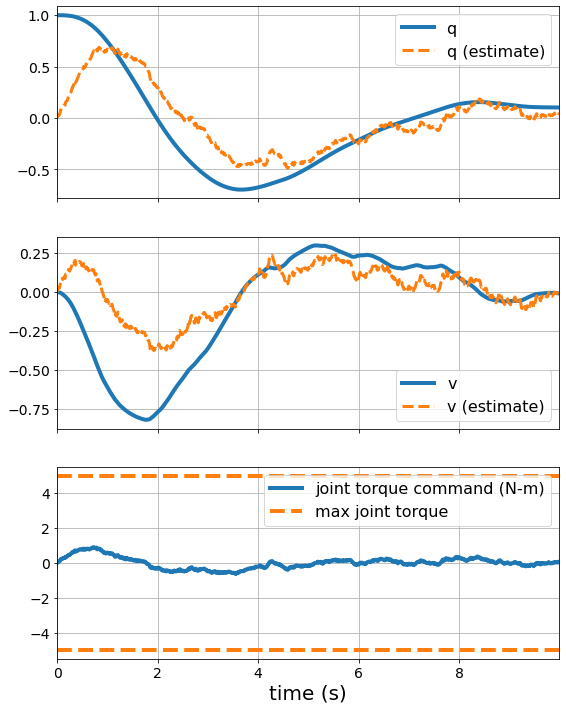

In [17]:
##############################################
# Restore the simulation to its initial state
#

# Choose initial conditions
q_platform = controller.q_e + 1.
q_wheel = 0.
v_platform = 0.
v_wheel = 0.

# Apply initial conditions
robot.set_state(np.array([q_platform, q_wheel]), np.array([v_platform, v_wheel]))

# - could also use:
#
#       robot.reset()
#
##############################################

##############################################
# Restore the observer to its initial state
#

controller.reset()

#
##############################################


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q': np.empty(num_steps, dtype=float),
    'v': np.empty(num_steps, dtype=float),
    'q_wheel': np.empty(num_steps, dtype=float),
    'v_wheel': np.empty(num_steps, dtype=float),
    'xhat': np.empty((2, num_steps), dtype=float),
    'tau': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_true, v_true, q_wheel_true, v_wheel_true = robot.get_sensor_measurements()
    
    # Add noise to sensor measurements
    q_meas = q_true + 1. * np.random.randn()
    
    # Log the state estimate
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(q_meas)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q'][step] = q_true
    data['v'][step] = v_true
    data['q_wheel'][step] = q_wheel_true
    data['v_wheel'][step] = v_wheel_true
    data['tau'][step] = tau
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

# Extract estimates of q and v
q_est = data['xhat'][0, :] + controller.q_e
v_est = data['xhat'][1, :] + controller.v_e

# Compare estimates to real values
fig, (ax_q, ax_v, ax_tau) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

ax_q.plot(data['t'], data['q'], label='q', linewidth=4)
ax_q.plot(data['t'], q_est, '--', label='q (estimate)', linewidth=3)
ax_q.grid()
ax_q.legend(fontsize=16)
ax_q.tick_params(labelsize=14)

ax_v.plot(data['t'], data['v'], label='v', linewidth=4)
ax_v.plot(data['t'], v_est, '--', label='v (estimate)', linewidth=3)
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)

ax_tau.plot(data['t'], data['tau'], label='joint torque command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C1')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C1')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])